In [1]:
import pygromos
from pygromos import files
from pygromos.files.topology import *
from pygromos.files.blocks.topology_blocks import *
from rdkit import Chem
from rdkit.Chem import AllChem
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines import smirnoff
from pygromos import data
from pygromos.files.gromos_system import *
from simtk.unit import *


In [2]:
ff = data.data_dir + "/ff/SMIRNOFF/frosst_12-12-18.xml"
forcefield = smirnoff.ForceField(ff)

0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Bonds' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Angles' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'ProperTorsions' tag. The SMIRNOFF spec converter is assuming it has a value of 'charmm'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'vdW' tag. The SMIRNOFF spec converter is assuming it has a value of 'Lennard-Jones-12-6'
0.1 SMIRNOFF spec did not allow the 'Electrostatics' tag. Adding it in 0.2 spec conversion, and assuming the following values:
	method: PME
	scale12: 0.0
	scale13: 0.0
	scale15: 1.0
	cutoff: 9.0
	cutoff_unit: angstrom
0.1 SMIRNOFF spec file does not contain 'method' attribute for 'NonBondedMethod/vdW'' tag. The SMIRNOFF spec converter is assuming it has a value of 'cutoff'
0.1 SMIRNOFF spe

In [3]:
rdkmol=Chem.MolFromMolFile("/home/mlehner/Documents/dev/molecule_174.sdf", removeHs = False)

In [4]:
moleculeFF = Molecule.from_rdkit(rdkmol)
topology = Topology.from_molecules(moleculeFF)

In [5]:
moleculeFF.name

''

In [6]:
molecule_force_list = forcefield.label_molecules(topology)

In [7]:
top = Top(input=data.data_dir+"/topology_templates/blank_template.top")

TITLE
PHYSICALCONSTANTS
TOPVERSION
SOLUTEMOLECULES
TEMPERATUREGROUPS
PRESSUREGROUPS
LJEXCEPTIONS
SOLVENTATOM
SOLVENTCONSTR


In [8]:
for molecule in molecule_force_list:
    for key in molecule["Bonds"]:
        force = molecule["Bonds"][key]
        #hQ = topology.atom(force[0]).atomic_number == 1 or topology.atom(force[1]).atomic_number == 1
        hQ =  not all([topology.atom(x).atomic_number != 1 for x in key]) 
        top.add_new_bond(k=force.k.value_in_unit(kilojoule / (mole * nanometer ** 2)), b0=force.length.value_in_unit(nanometer), atomI=key[0]+1, atomJ=key[1]+1, includesH=hQ)

In [9]:
for molecule in molecule_force_list:
    for key in molecule["Angles"]:
        force = molecule["Angles"][key]
        hQ =  not all([topology.atom(x).atomic_number != 1 for x in key])
        top.add_new_angle(k=force.k.value_in_unit(kilojoule / (mole * radian ** 2)), b0=force.angle.value_in_unit(degree), atomI=key[0]+1, atomJ=key[1]+1, atomK=key[2]+1, includesH=hQ)

In [10]:
for molecule in molecule_force_list:
    for key in molecule["ProperTorsions"]:
        force = molecule["ProperTorsions"][key]
        hQ =  not all([topology.atom(x).atomic_number != 1 for x in key])
        atomI=key[0]+1
        atomJ=key[1]+1
        atomK=key[2]+1
        atomL=key[3]+1
        k_list = force.k
        phase_list = force.phase
        per_list = force.periodicity
        for t in range(len(k_list)):
            CP=k_list[t].value_in_unit(kilojoule/mole)
            PD=phase_list[t].value_in_unit(degree)
            NP=per_list[t]
            top.add_new_torsiondihedral(CP=CP, PD=PD, NP=NP, atomI=atomI, atomJ=atomJ, atomK=atomK, atomL=atomL, includesH=hQ)

In [11]:
for molecule in molecule_force_list:
    for key in molecule["ImproperTorsions"]:
        force = molecule["ImproperTorsions"][key]
        hQ =  not all([topology.atom(x).atomic_number != 1 for x in key])
        atomI=key[0]+1
        atomJ=key[1]+1
        atomK=key[2]+1
        atomL=key[3]+1
        k_list = force.k
        phase_list = force.phase
        per_list = force.periodicity
        for t in range(len(k_list)):
            CP=k_list[t].value_in_unit(kilojoule/mole)
            PD=phase_list[t].value_in_unit(degree)
            NP=per_list[t]
            top.add_new_torsiondihedral(CP=CP, PD=PD, NP=NP, atomI=atomI, atomJ=atomJ, atomK=atomK, atomL=atomL, includesH=hQ)
if not hasattr(top, "IMPDIHEDRALTYPE"):
    top.add_block(blocktitle="IMPDIHEDRALTYPE", content=[])
if not hasattr(top, "IMPDIHEDRALH"):
    top.add_block(blocktitle="IMPDIHEDRALH", content=[])
if not hasattr(top, "IMPDIHEDRAL"):
    top.add_block(blocktitle="IMPDIHEDRAL", content=[])

In [12]:
exclusionlist=dict()

In [13]:
exclusionlist

{}

In [14]:
exclusionlist=dict()
for molecule in molecule_force_list:
    for key in molecule["Bonds"]:
        if not str(key[0]) in exclusionlist.keys():
            exclusionlist[str(key[0])] = {key[1]}
        exclusionlist[str(key[0])].add(key[1])
    for key in molecule["Angles"]:
        if not str(key[0]) in exclusionlist.keys():
            exclusionlist[str(key[0])] = {key[1]}
        exclusionlist[str(key[0])].add(key[1])
        exclusionlist[str(key[0])].add(key[2])
    for key in molecule["ProperTorsions"]:
        if not str(key[0]) in exclusionlist.keys():
            exclusionlist[str(key[0])] = {key[1]}
        exclusionlist[str(key[0])].add(key[1])
        exclusionlist[str(key[0])].add(key[2])
        exclusionlist[str(key[0])].add(key[3])
    for key in molecule["ImproperTorsions"]:
        if not str(key[0]) in exclusionlist.keys():
            exclusionlist[str(key[0])] = {key[1]}
        exclusionlist[str(key[0])].add(key[1])
        exclusionlist[str(key[0])].add(key[2])
        exclusionlist[str(key[0])].add(key[3])

In [15]:
exclusionlist

{'0': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17},
 '1': {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17},
 '2': {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15},
 '3': {1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17},
 '4': {0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17},
 '5': {0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17},
 '6': {0, 1, 5, 7, 8, 9, 16, 17},
 '8': {1, 2, 9, 10, 11},
 '10': {2, 3, 11, 12, 13},
 '12': {3, 4, 13, 14, 15},
 '14': {4, 5, 15, 16, 17},
 '16': {5, 17},
 '7': {0, 1, 5, 8, 9, 16, 17},
 '9': {1, 2, 10, 11},
 '11': {2, 3, 12, 13},
 '13': {3, 4, 14, 15},
 '15': {4, 5, 16, 17}}

In [16]:
moleculeFF.atoms[0].mass.value_in_unit(dalton)

12.01078

In [17]:
moleculeFF.atoms[0].atomic_number

6

In [18]:
moleculeItr = 1
for molecule in molecule_force_list:
    for key in molecule["vdW"]:
        force = molecule["vdW"][key]
        ATNM = int(key[0]) + 1
        MRES = moleculeItr
        IAC = 0
        MASS = moleculeFF.atoms[int(key[0])].mass.value_in_unit(dalton)
        CG = 0
        CGC = 0
        if str(key[0]) in exclusionlist:
            INE = list(exclusionlist[str(key[0])])
        else:
            INE = list()
        INE14 = list()
        epsilon = float(force.epsilon.value_in_unit(kilojoule_per_mole))
        rmin = 2 * force.rmin_half.value_in_unit(nanometer)
        C6 = 2 * epsilon * (rmin**6)
        C12 = epsilon * (rmin**12)
        IACname = force.id
        print(force.smirks)
        top.add_new_SOLUTEATOM(ATNM=ATNM, MRES=MRES, IAC=IAC, MASS=MASS, CG=CG, CGC=CGC, INE=INE, INE14=INE14, C6=C6, C12=C12, IACname=IACname)
    moleculeItr += 1 

[#6X4:1]
[#6X4:1]
[#6X4:1]
[#6X4:1]
[#6X4:1]
[#6X4:1]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]
[#1:1]-[#6X4]


In [19]:
len(moleculeFF.name)

0

In [20]:
if len(moleculeFF.name) >= 1:
    top.add_new_resname(moleculeFF.name)
else:
    top.add_new_resname(moleculeFF.hill_formula)

In [21]:
top.TEMPERATUREGROUPS.content

[['1'], ['1']]

In [22]:
moleculeFF.n_atoms

18

In [23]:
top.make_ordered()

In [24]:
print(top)

TITLE
Blank Template created with Pygromos

	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'
END
PHYSICALCONSTANTS
# FPEPSI: 1.0/(4.0*PI*EPS0) (EPS0 is the permittivity of vacuum)
138.9354
# HBAR: Planck's constant HBAR = H/(2* PI)
0.0635078
# SPDL: Speed of light (nm/ps)
299792.458
# BOLTZ: Boltzmann's constant kB
0.00831441
END
TOPVERSION
2.0
END
ATOMTYPENAME
2
n16
n2
END
RESNAME
1
C6H12
END
SOLUTEATOM
#   NRP: number of solute atoms
 	 18
#  ATNM: atom number
#  MRES: residue number
#  PANM: atom name of solute atom
#   IAC: integer (van der Waals) atom type code
#  MASS: mass of solute atom
#    CG: charge of solute atom
#   CGC: charge group code (0 or 1)
#   INE: number of excluded atoms
# INE14: number of 1-4 interactions
# ATNM MRES PANM IAC     MASS       CG  CGC INE
#                                           INE14
	1	1	_	1	12.01078	0	0	15	1	2	3	4	5	6
									7	8	9	10	11	14
									15	16	17
								0


In [25]:
top2 = Top(input=data.data_dir+"/topology_templates/blank_template.top")

TITLE
PHYSICALCONSTANTS
TOPVERSION
SOLUTEMOLECULES
TEMPERATUREGROUPS
PRESSUREGROUPS
LJEXCEPTIONS
SOLVENTATOM
SOLVENTCONSTR


In [27]:
top3 = openforcefield2gromos.openforcefield2gromos(moleculeFF, gromosTop=top2, forcefield_name=data.data_dir + "/ff/SMIRNOFF/frosst_12-12-18.xml").convert_return()

0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Bonds' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Angles' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'ProperTorsions' tag. The SMIRNOFF spec converter is assuming it has a value of 'charmm'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'vdW' tag. The SMIRNOFF spec converter is assuming it has a value of 'Lennard-Jones-12-6'
0.1 SMIRNOFF spec did not allow the 'Electrostatics' tag. Adding it in 0.2 spec conversion, and assuming the following values:
	method: PME
	scale12: 0.0
	scale13: 0.0
	scale15: 1.0
	cutoff: 9.0
	cutoff_unit: angstrom
0.1 SMIRNOFF spec file does not contain 'method' attribute for 'NonBondedMethod/vdW'' tag. The SMIRNOFF spec converter is assuming it has a value of 'cutoff'
0.1 SMIRNOFF spe

In [28]:
top3.make_ordered()

In [29]:
print(top3)

TITLE
Blank Template created with Pygromos

	name: 	 hill_formula: C6H12
	----------------------------------------
	| created from OpenForceField topology |
	| use Amber Block for OpenFF topology! |
	----------------------------------------

	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'
END
PHYSICALCONSTANTS
# FPEPSI: 1.0/(4.0*PI*EPS0) (EPS0 is the permittivity of vacuum)
138.9354
# HBAR: Planck's constant HBAR = H/(2* PI)
0.0635078
# SPDL: Speed of light (nm/ps)
299792.458
# BOLTZ: Boltzmann's constant kB
0.00831441
END
TOPVERSION
2.0
END
ATOMTYPENAME
2
n16
n2
END
RESNAME
1
C6H12
END
SOLUTEATOM
#   NRP: number of solute atoms
 	 18
#  ATNM: atom number
#  MRES: residue number
#  PANM: atom name of solute atom
#   IAC: integer (van der Waals) atom type code
#  MASS: mass of solute atom
#    CG: charge of solute atom
#   CGC: charge group code (0 or 1)
#   INE: number of excluded atoms
# INE14: number of 1-4 in

In [28]:
from pygromos.gromos import gromosPP, gromosXX

In [29]:
gromosPP.GromosPP(bin_path="/home/mlehner/gromosPlsPls/gromos++/BUILD/programs")


    GromosPP

    This is the class represents gromosPP.

    Attributes:
    -----------
    bin :   str, optional
        This is the path to the folder containing the binaries of gromosPP If None, the bash enviroment variables  will be used.
    
    Methods:
    ---------
		com_top
		dfmult
		ene_ana
		frameout
		jval
		make_top
		noe
		pdb2gromos
		pdb2seq
		prep_eds
		prep_noe
		protonate
		red_top
		sim_box
		tser

In [30]:
top3._orig_file_path = "/home/mlehner/Documents/dev/temp19/top3.top"

In [31]:
top3.write("/home/mlehner/Documents/dev/temp19/top3.top")

'/home/mlehner/Documents/dev/temp19/top3.top'

In [32]:
top4 = openforcefield2gromos(moleculeFF).convert_return()

0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Bonds' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Angles' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'ProperTorsions' tag. The SMIRNOFF spec converter is assuming it has a value of 'charmm'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'vdW' tag. The SMIRNOFF spec converter is assuming it has a value of 'Lennard-Jones-12-6'
0.1 SMIRNOFF spec did not allow the 'Electrostatics' tag. Adding it in 0.2 spec conversion, and assuming the following values:
	method: PME
	scale12: 0.0
	scale13: 0.0
	scale15: 1.0
	cutoff: 9.0
	cutoff_unit: angstrom
0.1 SMIRNOFF spec file does not contain 'method' attribute for 'NonBondedMethod/vdW'' tag. The SMIRNOFF spec converter is assuming it has a value of 'cutoff'
0.1 SMIRNOFF spe

In [33]:
top4.make_ordered()

In [34]:
print(top4)

TITLE
Blank Template created with Pygromos

	name: 	 hill_formula: C6H12
	----------------------------------------
	| created from OpenForceField topology |
	| use Amber Block for OpenFF topology! |
	----------------------------------------

	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'
END
PHYSICALCONSTANTS
# FPEPSI: 1.0/(4.0*PI*EPS0) (EPS0 is the permittivity of vacuum)
138.9354
# HBAR: Planck's constant HBAR = H/(2* PI)
0.0635078
# SPDL: Speed of light (nm/ps)
299792.458
# BOLTZ: Boltzmann's constant kB
0.00831441
END
TOPVERSION
2.0
END
ATOMTYPENAME
2
n16
n2
END
RESNAME
1
C6H12
END
SOLUTEATOM
#   NRP: number of solute atoms
 	 18
#  ATNM: atom number
#  MRES: residue number
#  PANM: atom name of solute atom
#   IAC: integer (van der Waals) atom type code
#  MASS: mass of solute atom
#    CG: charge of solute atom
#   CGC: charge group code (0 or 1)
#   INE: number of excluded atoms
# INE14: number of 1-4 in

In [35]:
top5 = openforcefield2gromos(moleculeFF, gromosTop=Top(input=None)).convert_return()

0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Bonds' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'Angles' tag. The SMIRNOFF spec converter is assuming it has a value of 'harmonic'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'ProperTorsions' tag. The SMIRNOFF spec converter is assuming it has a value of 'charmm'
0.1 SMIRNOFF spec file does not contain 'potential' attribute for 'vdW' tag. The SMIRNOFF spec converter is assuming it has a value of 'Lennard-Jones-12-6'
0.1 SMIRNOFF spec did not allow the 'Electrostatics' tag. Adding it in 0.2 spec conversion, and assuming the following values:
	method: PME
	scale12: 0.0
	scale13: 0.0
	scale15: 1.0
	cutoff: 9.0
	cutoff_unit: angstrom
0.1 SMIRNOFF spec file does not contain 'method' attribute for 'NonBondedMethod/vdW'' tag. The SMIRNOFF spec converter is assuming it has a value of 'cutoff'
0.1 SMIRNOFF spe

In [36]:
top5.make_ordered()

In [37]:
print(top5)

TITLE

	name: 	 hill_formula: C6H12
	----------------------------------------
	| created from OpenForceField topology |
	| use Amber Block for OpenFF topology! |
	----------------------------------------

	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'
END
PHYSICALCONSTANTS
# FPEPSI: 1.0/(4.0*PI*EPS0) (EPS0 is the permittivity of vacuum)
138.9354
# HBAR: Planck's constant HBAR = H/(2* PI)
0.0635078
# SPDL: Speed of light (nm/ps)
299792.458
# BOLTZ: Boltzmann's constant kB
0.00831441
END
TOPVERSION
2.0
END
ATOMTYPENAME
2
n16
n2
END
RESNAME
1
C6H12
END
SOLUTEATOM
#   NRP: number of solute atoms
 	 18
#  ATNM: atom number
#  MRES: residue number
#  PANM: atom name of solute atom
#   IAC: integer (van der Waals) atom type code
#  MASS: mass of solute atom
#    CG: charge of solute atom
#   CGC: charge group code (0 or 1)
#   INE: number of excluded atoms
# INE14: number of 1-4 interactions
# ATNM MRES PANM IAC     M

In [38]:
top5.write("/home/mlehner/Documents/dev/test2.top")

'/home/mlehner/Documents/dev/test2.top'

In [39]:
mol2=AllChem.MolFromSmarts("[C:1]=C(C)C(=O)OC")

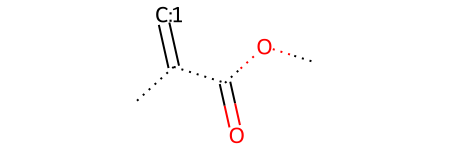

In [40]:
mol2

In [41]:
for a in mol2.GetAtoms():
    print(a.GetAtomicNum())
    print(a.GetIdx())
    print(a.GetTotalNumHs())
    print(a.GetAtomMapNum())
    print("----------------")

6
0
2
1
----------------
6
1
0
0
----------------
6
2
3
0
----------------
6
3
0
0
----------------
8
4
0
0
----------------
8
5
0
0
----------------
6
6
3
0
----------------


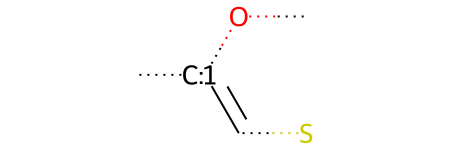

In [42]:
AllChem.MolFromSmarts("[#16][#6]=[#6:1]([#6])[#8][#6]")